# Debugging HIP applications

There is an almost infinite number of ways that software can mess up. Thankfully in HIP there is support for debugging programs using the underlying platform's debugging tools. On an AMD platform  the debugging tool is [rocgdb](https://github.com/ROCm-Developer-Tools/ROCgdb), and on a CUDA platform it is [cuda-gdb](https://developer.nvidia.com/cuda-gdb). Using the following techniques we can squash a majority of bugs in HIP programs:

* Checking the return codes on every HIP function call.
* Checking inputs, outputs and memory handling before checking kernels.
* Using **printf** within kernels.
* Using **rocgdb** or **cuda-gdb** to check memory access violations.

## Buggy matrix multiplication

We introduce an **bug** into our matrix multiplication kernel and see what techniques can uncover the error. In this instance we **intentionally remove** the guard check that prevents the kernel from setting values outside the domain of **C**. The size of matrices **A**, **B**, and **C** are set to (72,72) with row-major ordering. In the kernel we specify that dimension 0 of the grid maps to dimension 1 in the matrices because dimension 1 is the contiguous dimension in row-major ordering. Similarly, in the kernel we say that dimension 1 of the grid maps to dimension 0 of the matrices.

We choose a block size of (16,4,1). Since an integer number of blocks must compose the grid in each dimension, a grid size of $(80,72,1)$ is the smallest size that will adequately cover the matrices with $(5,18,1)$ blocks in each dimension. This grid is then mapped to a size of (72,80) as shown in the diagram below.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_boundaries.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Running off the end of the array due to differences between array size and global size.</figcaption>
</figure>

If we do not have a guard in place, then array accesses into the matrices will run off the end in dimension 1, resulting in a memory access violation. We remove the guard in the kernel section of [mat_mult_bug.cpp](mat_mult_bug.cpp), as shown below:

```C++
// mat_mult_badmem.cpp source

// standard matrix multiply kernel without a guard check
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
} 
```

## Run the buggy application

If we try running this code then the maximum residual is (sometimes much) larger than expected.

In [3]:
!make clean; make mat_mult_bug.exe; ./mat_mult_bug.exe

rm -r *.exe
hipcc -O1 -ggdb -g -fopenmp -I../include mat_mult_bug.cpp -o mat_mult_bug.exe 
Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    536 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)
Maximum error (infinity norm) is: 2.15198e+38


Notice that with this HIP implementation the code completes without crashing, even though we know there is a memory access violation. Some HIP implementations (GPU ones in particular) do not have strict memory access violation checks. Memory access violations can result in undefined behaviour. Due to OS security, CPU implementations are more sensitive to memory access violations than GPU implementations, where memory allocations may be padded and memory access violations are not as protected.

## Visual inspection of outputs

We load the files **array_A.dat**, **array_B.dat**, and **array_C.dat** into memory and compare results.

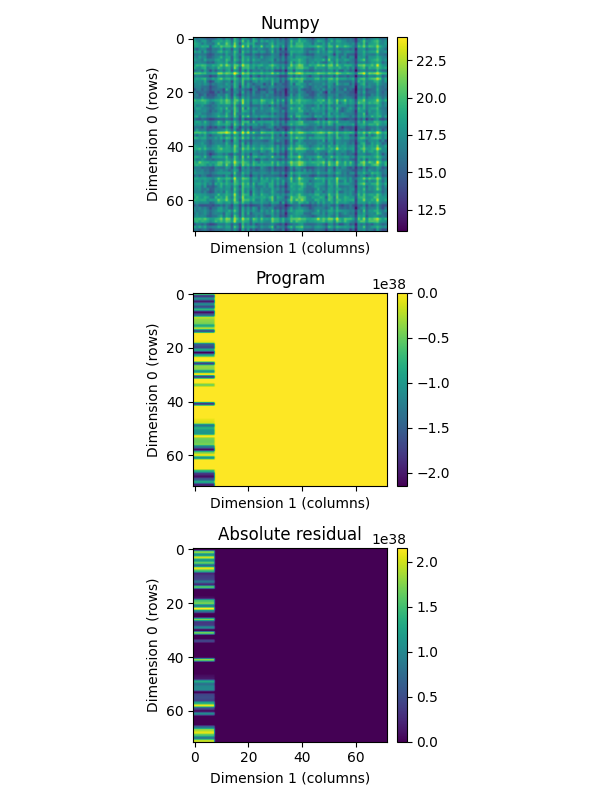

In [4]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

# Data type to use for matrices
dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

NCOLS_A=defines["NCOLS_A"]
NROWS_C=defines["NROWS_C"]
NCOLS_C=defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.load_data()
mat_mul.check_data()

The effect of the memory error is noticeable when we perform a direct comparison between Python and our HIP application. Row 0 of the of the output is unaffected, however all subsequent rows are affected by the bug because for each row the kernel spills over to 8 cells of the next row. Often the numbers in the output are nonsense because we have gone outside the bounds of matrices B for the read, and off the bounds of matrix C for the last line of the write.

## Checking HIP calls 

Inspecting the return codes of HIP calls is best practice. Many API errors are caught this way. In this lesson we have already checked return codes and they haven't signalled an error. We need to dig deeper....

## Checking memory access by filling with known values

When trying to get your HIP codes working it is helpful to first make sure that your memory accesses are valid. In this instance we change the kernel so that it fills **C** with a **known value**. In this case we fill it with **i1** as shown in the kernel from [mat_mult_memcheck.cpp](mat_mult_memcheck.cpp). Run the code and check the results by running the visual check above.

```C++
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=(float)i1;
    //}
}
```


In [5]:
!make mat_mult_memcheck.exe; ./mat_mult_memcheck.exe

hipcc -O1 -ggdb -g -fopenmp -I../include mat_mult_memcheck.cpp -o mat_mult_memcheck.exe 
Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    536 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)
Maximum error (infinity norm) is: 64.9817


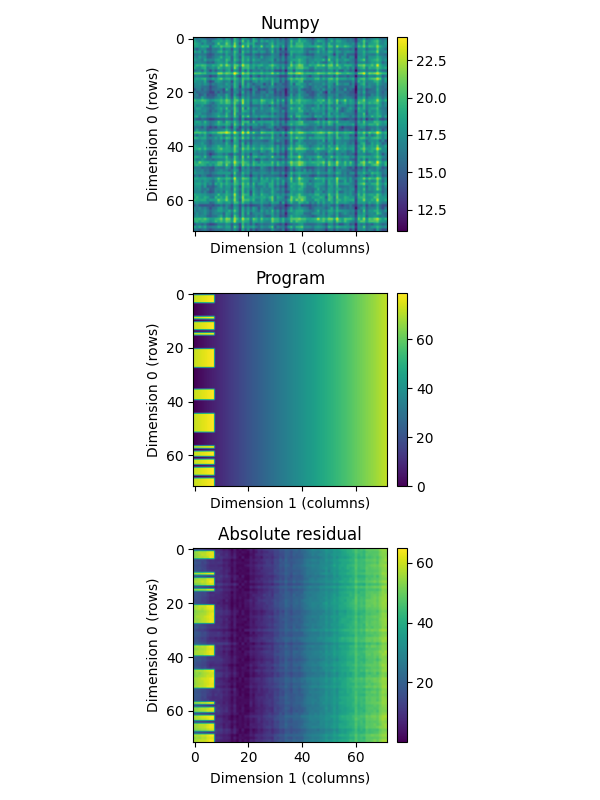

In [6]:
mat_mul.load_data()
mat_mul.check_data()

In the visual check some lines are filled with higher values of **i1** whereas others are filled with lower values. This is because in the buggy implementation two different kernel invocations are writing to the **same global memory location**. Also note that values have stabilised becuase the kernel is not using values read from off the bounds of **B**. This illustrates that one cannot rely on the order in which workgroups complete and the order in which memory updates are flushed back to global memory. Checking your memory inputs and outputs using **known** values in the kernel is a powerful **first pass** technique for debugging. It is good practice to make sure your memory transfers and accesses are ok before debugging your kernel further.

## Debugging with **printf**

Within HIP and CUDA there is support for printing values from **within** a kernel using the **printf** function. Output from printf in the kernel gets routed to standard output on the command line. Unfortunately printf support in HIP is a bit patchy and it may or may not work for you. It didn't work for me using HIP on my AMD integrated GPU. We edit the kernel source in file [mat_mult_printf.cpp](mat_mult_printf.cpp) to include a printf statement that triggers whenever we exceed the size of the matrices along dimension 1.

```C
// Kernel with printf statement 
__kernel void mat_mult_printf (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(0); 
    size_t i1=get_global_id(1); 
    
    // Scratch variable
    float temp=0.0; 

    // Comment out the guard mechanism 
    // to make sure we do not go
    // outside the boundaries of matrix C
    if ((i1>N1_C-1) && (i0==0)) {
        printf("i1 is %d\n", (int)i1);
    }
    
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
} 
```

Now run the program. 

In [7]:
!make mat_mult_printf.exe; ./mat_mult_printf.exe

hipcc -O1 -ggdb -g -fopenmp -I../include mat_mult_printf.cpp -o mat_mult_printf.exe 
Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    536 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)
Maximum error (infinity norm) is: 2.27243e+38


If **printf** is working we observe that the workgroups do indeed encounter values of **i1** that go beyond the bounds of the array.

## Debugging HIP kernels with ROCGDB

On Setonix, AMD has the **rocgdb** debugger available to perform debugging. 

### Compiler options for debugging

From this [source](https://docs.amd.com/bundle/ROCDubugger-User-Guide/page/AMD-GPU.html) AMD recommends setting your code up for debugging by compiling with `hipcc` and the flags `-O0 -ggdb` and the appropriate `--offload-arch` flag for your architecture. For MI250 GPUs the flag is `--offload-arch=gfx90a`. On some AMD architectures (other than gfx90a) the `-O0` flag with hipcc can produce faulty code, see [this issue on Github](https://github.com/ROCm-Developer-Tools/HIP/issues/3183) for more information.

This command 

```
hipcc -O0 -ggdb mat_mult_bug.cpp -o mat_mult_bug.exe
```

is intended to compile the file [mat_mult_bug.cpp](mat_mult_bug.cpp) with debugging support, however we use the `-O1` flag to avoid the compiler bug.

```
hipcc -O1 -ggdb mat_mult_bug.cpp -o mat_mult_bug.exe
```

### Running ROCGDB

Within ROCGDB for GPU archicectures there is the concept of **threads** and **lanes**. A *thread* is charge of a wavefront, which is executed on a compute unit, and a lane is a shader core core that executes the instructions in parallel as part of a wavefront.

We execute **rocgdb** for **mat_mult_bug.exe** as follows:

```bash
rocgdb --args ./mat_mult_bug.exe 
```

We set a breakpoint in the **mat_mult** kernel by typing this at the gdb command line

```gdb
b mat_mult
run
```

type `y` to make breakpoint pending on future shared library load then type

```bash
disable
```

to disable the breakpoint, otherwise all the other threads will break at this point too. Now type

```bash
info threads
```

To see what threads are available. Since we have a grid size of (80,72,1) and a block size of (16,4,1) the number of blocks in each dimension should be (5,18,1) and we would  have scheduled 5x18 = 90 wavefronts. 

```bash
* 5    AMDGPU Wave 6:1:1:1 (0,0,0)/0 "mat_mult_bug.ex"      mat_mult (A=<optimized out>, ...
  6    AMDGPU Wave 6:1:1:2 (1,0,0)/0 "mat_mult_bug.ex"      mat_mult (A=<optimized out>, ...
  7    AMDGPU Wave 6:1:1:3 (2,0,0)/0 "mat_mult_bug.ex"      mat_mult (A=<optimized out>, ...
  ...
  ...
  94   AMDGPU Wave 6:1:1:90 (4,17,0)/0 "mat_mult_bug.ex"    mat_mult (A=<optimized out>, ...
```

The output on the last line e.g **6:1:1:90 (4,17,0)/0** is a set of coordinates within the grid. It is translated as

| Key | Explanation | Value | 
| ----------- | ----------- | ---- |
| agent-id    | Agent Target ID | 6      | 
| queue-id    | Queue Target ID |  1     |
| dispatch-num | Dispatch Number | 1
| wave-id | Wavefront ID | 90
| (blockIDdx.x, blockIdx.y, blockIdx.z) | Coordinates of the block within the grid | (4,17,0) |
| work-group-thread-index | index of thread within block | 0 |

We can use the **thread** command to move to the thread id that corresponds to wave-id == 90. Something like the following:

```bash
thread 94
```

The command **info lanes** shows all the available lanes for that block

```bash
info lanes
```

```bash
  Id   State Target Id                                Frame 
* 0    A     AMDGPU Lane 6:1:1:90/0 (4,17,0)[0,0,0]   mat_mult (A=<optimized out>, ...
  1    A     AMDGPU Lane 6:1:1:90/1 (4,17,0)[1,0,0]   mat_mult (A=<optimized out>, ...
  ...
  ...
  63   A     AMDGPU Lane 6:1:1:90/63 (4,17,0)[15,3,0] mat_mult (A=<optimized out>, ...
```

The set of coordinates for each lane is as before, i.e **Lane 6:1:1:90/0 (4,17,0)[0,0,0]** however there is an extra set of coordinates, i,e [0,0,0] for the lanes' [x,y,z] position within the block. We use the **lane** command to change to the last lane in the wavefront

```bash
lane 63
```

At the time of writing ROCGDB doesn't appear to support printing private kernel variables from within a lane. According to [this source on Github](https://github.com/ROCm-Developer-Tools/ROCgdb/issues/14#issuecomment-1423581387), printing kernel variables is **hopefully** going to be introduced with a future version. Until this feature is available we can either use **printf** from within a kernel or **view variables by examining register contents** directly. Here is how to use registers to see what we need.

#### Viewing register contents

We turn on the view of assembly code to see which registers are being worked with.

```bash
set  disassemble-next-line on
```

Now we can type `step` to walk through each line of execution or `stepi` to step through a single machine instruction. The command `info registers` prints all available registers. The registers that start with **s** are scalar registers that are used for the whole wavefront. The registers that start with **v** are vector registers. Each work-item **i** in the wavefront has access to the vector register at index **i**.

Stepping through the program we are looking for the lines where the value of **i1** is being computed. Something like this:

```ASM
33	    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
=> 0x00007ffff632303c <_Z8mat_multPfS_S_mmm+60>:	08 00 00 68	v_add_u32_e32 v0, s8, v0
   0x00007ffff6323040 <_Z8mat_multPfS_S_mmm+64>:	22 00 85 bf	s_cbranch_scc1 34  # 0x7ffff63230cc <_Z8mat_multPfS_S_mmm+204>
   0x00007ffff6323044 <_Z8mat_multPfS_S_mmm+68>:	04 02 e8 d1 06 25 00 02	v_mad_u64_u32 v[4:5], s[2:3], v6, s18, 0
```

In this output it appears that the vector register **v0** is populated with the result of the calculation. We can print the contents of vector register **v0** as an unsigned integer, like this.

```gdb
(gdb) print/u $v0
$6 = {64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 64, 65, 66, 67, 
  68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79}
```

Since we are in lane 63 we will be using the **last** value in the vector register at index 63. The value for **i1** is therefore 79, which is outside the bounds of the matrices. If, for example we know that register **v0** is supposed to be a float we can print it using the `/f` formatting string to format the result as a float. [This site](https://sourceware.org/gdb/onlinedocs/gdb/Output-Formats.html) has all the formatting codes for how to print registers.

```gdb
(gdb) print/f $v0
$18 = {8.96831017e-44, 9.10844002e-44, 9.24856986e-44, 9.38869971e-44, 9.52882956e-44, 9.6689594e-44, 9.80908925e-44, 9.9492191e-44, 1.00893489e-43, 
  1.02294788e-43, 1.03696086e-43, 1.05097385e-43, 1.06498683e-43, 1.07899982e-43, 1.0930128e-43, 1.10702579e-43, 8.96831017e-44, 9.10844002e-44, 
  9.24856986e-44, 9.38869971e-44, 9.52882956e-44, 9.6689594e-44, 9.80908925e-44, 9.9492191e-44, 1.00893489e-43, 1.02294788e-43, 1.03696086e-43, 
  1.05097385e-43, 1.06498683e-43, 1.07899982e-43, 1.0930128e-43, 1.10702579e-43, 8.96831017e-44, 9.10844002e-44, 9.24856986e-44, 9.38869971e-44, 
  9.52882956e-44, 9.6689594e-44, 9.80908925e-44, 9.9492191e-44, 1.00893489e-43, 1.02294788e-43, 1.03696086e-43, 1.05097385e-43, 1.06498683e-43, 
  1.07899982e-43, 1.0930128e-43, 1.10702579e-43, 8.96831017e-44, 9.10844002e-44, 9.24856986e-44, 9.38869971e-44, 9.52882956e-44, 9.6689594e-44, 
  9.80908925e-44, 9.9492191e-44, 1.00893489e-43, 1.02294788e-43, 1.03696086e-43, 1.05097385e-43, 1.06498683e-43, 1.07899982e-43, 1.0930128e-43, 
  1.10702579e-43}
```

### Enable memory accesss checking

Within GDB the command

```bash
set amdgpu precise-memory on
```

will turn on checking for memory access violations



## Debugging HIP code with CUDA tools

If you have the **HIP_PLATFORM** environment variable set to **nvidia** the hipcc compiler will use nvcc on the backend. This means all of the tools for debugging CUDA programs are at your disposal. Here we use **cuda-gdb** to debug kernels.

### Hipcc Compiler options for cuda-gdb

CUDA kernels require the **-g** and **-G** flags for debugging. In addition the **-gencode** flag compiles code for a specific architecture. In this case we use **-gencode arch=compute_61,code=compute_61** to compile for all device architectures including Pascal and later.

```bash
hipcc -g -G -gencode arch=compute_61,code=compute_61 -Xcompiler -fopenmp mat_mult_bug.cpp -o mat_mult_bug.exe
```

### Running cuda-gdb

Running the buggy matrix multiplication code under **cuda-gdb** is accompished with the command:

```bash
cuda-gdb --args ./mat_mult_bug.exe
```

Within cuda-gdb we set a breakpoint at the **mat_mult** kernel, similar to what we did with rocgdb.

```gdb
break mat_mult
```

Now run the code and it should stop at the kernel

```gdb
run
```

The **info cuda kernels** command in GDB shows what commands are currently active.
```gdb
info cuda kernels

 *      0      -   0    1 Active 0x3fffffff (5,18,1) (16,4,1) mat_mult(A=0x7fffc5e00000, B=0x7fffc5e05200, C=0x7fffc5e0a400, N1_A=72, N0_C=72, N1_C=72) 
```

The output shows that kernel 0 has 5 blocks in dimension 0, 18 blocks in dimension 1 with a block size of (16,4,1). If we keep this breakpoint then other threads will trip over it. Disable it with

```bash
disable
```

Now we can switch focus to the very last thread in block coordinates (4,17,0) within the grid and thread coordinates (15,3,0) within the last block.

```gdb
cuda block 4,17,0 thread 15,3,0
```

Now we can step through the lines of code with **next** (or **n**) until the lines for **i0** and **i1** have been executed.

```gdb
n
```

```
(cuda-gdb) next
32    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
(cuda-gdb) next
33    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
```

If we use **print** to print variables **i0** and **i1** we see that **i0==71** and **i1==79**.

```gdb
(cuda-gdb) print i0
$1 = 71
(cuda-gdb) print i1
$2 = 79
```

As these coordinates are off the end of the array it will cause a memory access problem.


### Memory access checking with **compute-sanitizer**

The **memcheck** tool in NVIDIA's **compute-sanitizer** has the ability to check memory access errors in kernels. We run the application as follows and it has clearly picked up the memory access violation.

In [19]:
!compute-sanitizer --tool memcheck --padding 0 --target-processes all ./mat_mult_bug.exe 

========= COMPUTE-SANITIZER
Device id: 0
	name:                                    NVIDIA GeForce RTX 3060 Laptop GPU
	global memory size:                      6226 MB
	available registers per block:           65536 
	maximum shared memory size per block:    49 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,64)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65535,65535)
========= Invalid __global__ read of size 4 bytes
=========     at 0xc30 in /home/toby/Pelagos/Projects/HIP_Course/course_material/L4_Debugging/mat_mult_bug.cpp:49:mat_mult(float *, float *, float *, unsigned long, unsigned long, unsigned long)
=========     by thread (8,0,0) in block (4,5,0)
=========     Address 0x7fd1cf20a300 is out of bounds
=========     and is 1 bytes after the nearest allocation at 0x7fd1cf205200 of size 20,736 bytes
=========     Saved host backtrace up to driver entry point at kernel

## Summary

In this section we have covered a number of techniques for finding errors in HIP applications. Checks on the return values for HIP function calls is good practice for making sure HIP software is running correctly. Additional  techniques such as filling memory with known values, using `printf`, and debugging with `rocgdb` or `cuda-gdb` can help uncover software errors.

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the <a href="https://pawsey.org.au">Pawsey Supercomputing Centre</a>.<br>
</address>